In [ ]:
import numpy as np
from scipy.stats import anderson_ksamp
import matplotlib.pyplot as plt
import json
import pandas as pd
import seaborn as sns

In [ ]:
num_points = 100
dist1 = np.random.rand(num_points)
dist2 = np.random.randn(num_points)
dist3 = np.random.rand(num_points) 

In [ ]:
fig, ax = plt.subplots(1,1)
ax.hist(dist1, histtype="step")
ax.hist(dist2, histtype="step")
ax.hist(dist3, histtype="step")
plt.show()

In [145]:
tmp = anderson_ksamp([dist3, dist1])
ad_stat = tmp.significance_level
ad_stat = (ad_stat - 0.001)/ (0.25 - 0.001)
print(ad_stat)

1.0


/tmp/ipykernel_17061/4147612468.py:1: UserWarning: p-value capped: true value larger than 0.25
  tmp = anderson_ksamp([dist3, dist1])


In [146]:
tmp

Anderson_ksampResult(statistic=-0.6508312956466941, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), significance_level=0.25)

TODO: try reading in multiple all_pos by creating a list of dictionaries of all_pos

In [160]:
all_pos_path = [
     "/mnt/c/Users/saurabh.mogre/OneDrive - Allen Institute/Projects/AICS/cellpack/out/analyze/test_analyze/jitter/all_positions.json",
     "/mnt/c/Users/saurabh.mogre/OneDrive - Allen Institute/Projects/AICS/cellpack/out/analyze/test_analyze_large_pex/jitter/all_positions.json",
]
all_pos_list = []
for file_path in all_pos_path:
     with open(file_path, 'r') as j:
          all_pos_list.append(json.loads(j.read()))

TODO: loop over the list of all_pos, use index of loop as a seed suffix

In [161]:
all_objs = {}
for packing_id, all_pos in enumerate(all_pos_list):
    for seed, object_dict in all_pos.items():
        for obj, positions in object_dict.items():
            positions = np.array(positions)
            if obj not in all_objs:
                all_objs[obj] = {}
            seed_key = f"{seed}_{packing_id}"
            if seed_key not in all_objs[obj]:
                all_objs[obj][seed_key] = {}
            for ct, dim in enumerate(["x", "y", "z"]):
                all_objs[obj][seed_key][dim] = positions[:, ct]

In [155]:
tmp = all_objs["ext__peroxisome"]

In [156]:
tmp

{'0_0': {'x': array([ 8.43472752, 80.6753475 , 79.07848824, 48.31798022, 11.8166119 ,
          2.59498652, 41.38273815, 97.38131217,  1.61228213, 47.57586005,
         32.10161426, 92.90081782, 56.89735669, 68.11054213, 71.61796589,
         43.29696579,  3.33698301, 51.39846477, 15.81173079, 48.57914671,
         70.5116433 , 52.5264064 ,  2.45772979, 83.03840393, 85.56587062,
         82.37726933, 87.41210947, 55.86411634, 77.19131027, 42.9487405 ,
          6.79702808, 68.31193383, 92.10425852, 24.15950833, 92.64192249,
          6.30360823, 49.19629372, 17.74840751, 81.09933661, 19.34583564,
         38.38964165, 37.05662892, 77.16951071,  5.72049305, 38.65222468,
         53.46734172,  6.37619125, 23.34820025, 77.31133276, 95.71774356]),
  'y': array([81.68499796, 96.56270347, 82.00259349, 26.78172596, 87.55675251,
         41.11083976, 66.72089244, 39.79374051, 63.93701068, 58.47985698,
         61.20615546, 66.73739053, 25.49146901, 75.62360224, 98.42640409,
         39.6735331

In [162]:
num_seeds = len(all_objs["ext__peroxisome"])
similarity = np.zeros((3, num_seeds, num_seeds))
score = np.zeros((3, num_seeds, num_seeds))

for rc, (seed1, pos_dict1) in enumerate(all_objs["ext__peroxisome"].items()):
    for cc, (seed2, pos_dict2) in enumerate(all_objs["ext__peroxisome"].items()):
        for dc, dim in enumerate(["x", "y", "z"]):
            arr1 = pos_dict1[dim]
            arr2 = pos_dict2[dim]
            # print(arr1)
            # print(arr2)
            # print()
            print(seed1, seed2)
            if len(arr1)==1 or len(arr2)==1:
                tmp = 0.25
                score_val = 0
            else:
                ad_stat = anderson_ksamp([arr1, arr2]) 
                tmp = ad_stat.significance_level
                score_val = ad_stat.statistic
            similarity[dc, rc, cc] = (tmp - 0.001) / (0.25 - 0.001)
            score[dc, rc, cc] = score_val

0_0 0_0
0_0 0_0
0_0 0_0
0_0 1_0
0_0 1_0
0_0 1_0
0_0 2_0
0_0 2_0
0_0 2_0
0_0 3_0
0_0 3_0
0_0 3_0
0_0 4_0
0_0 4_0
0_0 4_0
0_0 5_0
0_0 5_0
0_0 5_0
0_0 6_0
0_0 6_0
0_0 6_0
0_0 7_0
0_0 7_0
0_0 7_0
0_0 8_0
0_0 8_0
0_0 8_0
0_0 9_0
0_0 9_0
0_0 9_0
0_0 0_1
0_0 0_1
0_0 0_1
0_0 1_1
0_0 1_1
0_0 1_1
0_0 2_1
0_0 2_1
0_0 2_1
0_0 3_1
0_0 3_1
0_0 3_1
0_0 4_1
0_0 4_1
0_0 4_1
0_0 5_1
0_0 5_1
0_0 5_1
0_0 6_1
0_0 6_1
0_0 6_1
0_0 7_1
0_0 7_1
0_0 7_1
0_0 8_1
0_0 8_1
0_0 8_1
0_0 9_1
0_0 9_1
0_0 9_1
1_0 0_0
1_0 0_0
1_0 0_0
1_0 1_0
1_0 1_0
1_0 1_0
1_0 2_0
1_0 2_0
1_0 2_0
1_0 3_0
1_0 3_0
1_0 3_0
1_0 4_0
1_0 4_0
1_0 4_0
1_0 5_0
1_0 5_0
1_0 5_0
1_0 6_0
1_0 6_0
1_0 6_0
1_0 7_0
1_0 7_0
1_0 7_0
1_0 8_0
1_0 8_0
1_0 8_0
1_0 9_0
1_0 9_0
1_0 9_0
1_0 0_1
1_0 0_1
1_0 0_1
1_0 1_1
1_0 1_1
1_0 1_1
1_0 2_1
1_0 2_1
1_0 2_1
1_0 3_1
1_0 3_1
1_0 3_1
1_0 4_1
1_0 4_1
1_0 4_1
1_0 5_1
1_0 5_1
1_0 5_1
1_0 6_1
1_0 6_1
1_0 6_1
1_0 7_1
1_0 7_1
1_0 7_1
1_0 8_1
1_0 8_1
1_0 8_1
1_0 9_1
1_0 9_1
1_0 9_1
2_0 0_0
2_0 0_0
2_0 0_0
2_0 1_0
2_0 1_0


/tmp/ipykernel_17061/3638922578.py:18: UserWarning: p-value capped: true value larger than 0.25
  ad_stat = anderson_ksamp([arr1, arr2])
/tmp/ipykernel_17061/3638922578.py:18: UserWarning: p-value floored: true value smaller than 0.001
  ad_stat = anderson_ksamp([arr1, arr2])


8_0 3_1
8_0 3_1
8_0 3_1
8_0 4_1
8_0 4_1
8_0 4_1
8_0 5_1
8_0 5_1
8_0 5_1
8_0 6_1
8_0 6_1
8_0 6_1
8_0 7_1
8_0 7_1
8_0 7_1
8_0 8_1
8_0 8_1
8_0 8_1
8_0 9_1
8_0 9_1
8_0 9_1
9_0 0_0
9_0 0_0
9_0 0_0
9_0 1_0
9_0 1_0
9_0 1_0
9_0 2_0
9_0 2_0
9_0 2_0
9_0 3_0
9_0 3_0
9_0 3_0
9_0 4_0
9_0 4_0
9_0 4_0
9_0 5_0
9_0 5_0
9_0 5_0
9_0 6_0
9_0 6_0
9_0 6_0
9_0 7_0
9_0 7_0
9_0 7_0
9_0 8_0
9_0 8_0
9_0 8_0
9_0 9_0
9_0 9_0
9_0 9_0
9_0 0_1
9_0 0_1
9_0 0_1
9_0 1_1
9_0 1_1
9_0 1_1
9_0 2_1
9_0 2_1
9_0 2_1
9_0 3_1
9_0 3_1
9_0 3_1
9_0 4_1
9_0 4_1
9_0 4_1
9_0 5_1
9_0 5_1
9_0 5_1
9_0 6_1
9_0 6_1
9_0 6_1
9_0 7_1
9_0 7_1
9_0 7_1
9_0 8_1
9_0 8_1
9_0 8_1
9_0 9_1
9_0 9_1
9_0 9_1
0_1 0_0
0_1 0_0
0_1 0_0
0_1 1_0
0_1 1_0
0_1 1_0
0_1 2_0
0_1 2_0
0_1 2_0
0_1 3_0
0_1 3_0
0_1 3_0
0_1 4_0
0_1 4_0
0_1 4_0
0_1 5_0
0_1 5_0
0_1 5_0
0_1 6_0
0_1 6_0
0_1 6_0
0_1 7_0
0_1 7_0
0_1 7_0
0_1 8_0
0_1 8_0
0_1 8_0
0_1 9_0
0_1 9_0
0_1 9_0
0_1 0_1
0_1 0_1
0_1 0_1
0_1 1_1
0_1 1_1
0_1 1_1
0_1 2_1
0_1 2_1
0_1 2_1
0_1 3_1
0_1 3_1
0_1 3_1
0_1 4_1
0_1 4_1


In [154]:
score[0]

array([[-1.33824468, -1.33824468, -1.33824468, -1.33824468, -1.33824468,
        -1.33824468, -1.33824468, -1.33824468, -1.33824468, -1.33824468,
        -0.01854502, -0.01854502, -0.01854502, -0.01854502, -0.01854502,
        -0.01854502, -0.01854502, -0.01854502, -0.01854502, -0.01854502],
       [-1.33824468, -1.33824468, -1.33824468, -1.33824468, -1.33824468,
        -1.33824468, -1.33824468, -1.33824468, -1.33824468, -1.33824468,
        -0.01854502, -0.01854502, -0.01854502, -0.01854502, -0.01854502,
        -0.01854502, -0.01854502, -0.01854502, -0.01854502, -0.01854502],
       [-1.33824468, -1.33824468, -1.33824468, -1.33824468, -1.33824468,
        -1.33824468, -1.33824468, -1.33824468, -1.33824468, -1.33824468,
        -0.01854502, -0.01854502, -0.01854502, -0.01854502, -0.01854502,
        -0.01854502, -0.01854502, -0.01854502, -0.01854502, -0.01854502],
       [-1.33824468, -1.33824468, -1.33824468, -1.33824468, -1.33824468,
        -1.33824468, -1.33824468, -1.33824468, -

In [ ]:
tmp = np.zeros((2,3,4))

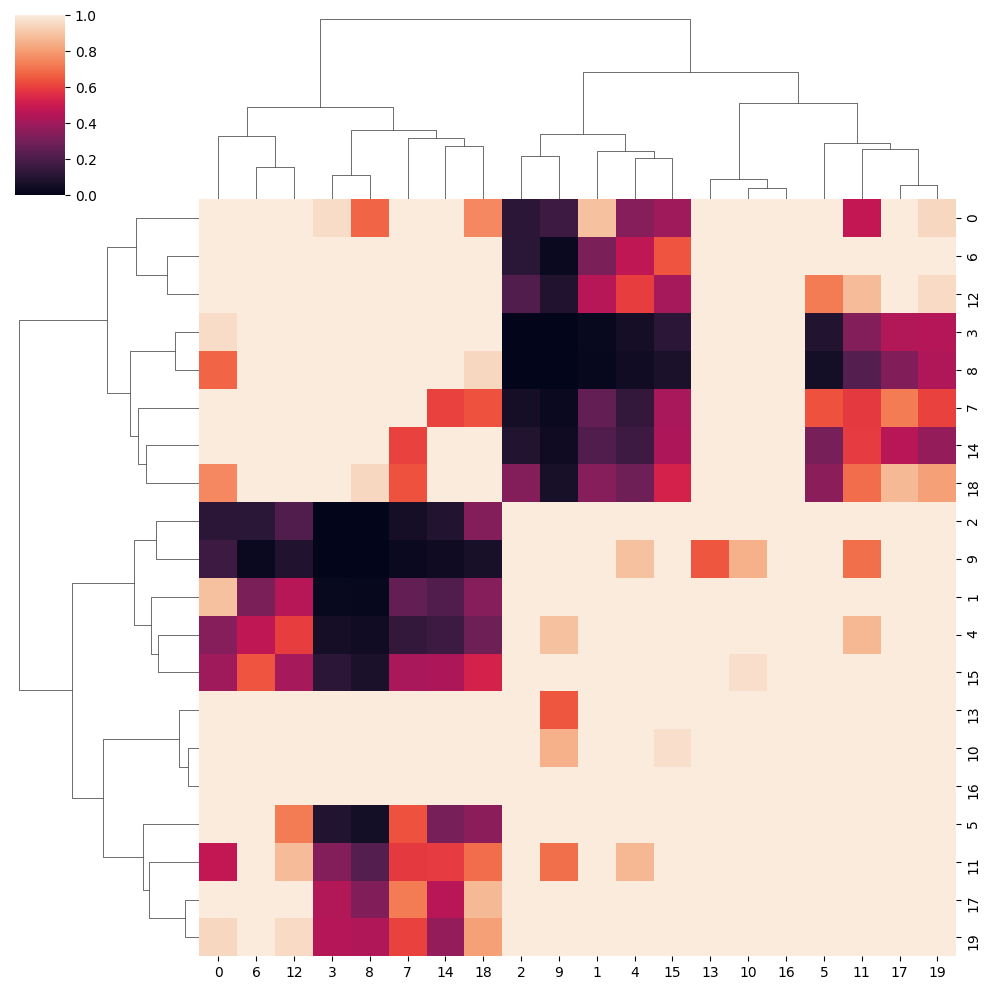

In [164]:
sns.clustermap(similarity[1])

In [ ]:
thetvals = np.arange(0, np.pi, np.pi/128)
phivals = np.arange(0, 2 * np.pi, np.pi/128)

In [ ]:
phivals